# Python Jupyter Supplement: Getting started with GP modeling

The following notebook is an electronic supplement to the chapter **Gaussian Process Models for Financial Mathematics and Actuarial Science** by M. Ludkovski and J. Risk.

In particular, most of the plots and figures appearing in Section 2 and based on the respective synthetic example can be obtained by executing the code below. 

## Libraries and Setup

This notebook uses the following Python libraries:
   - ``numpy``: basic linear algebra operations
   - ``sklearn``: for pre-scaling utility
   - ``pandas``: to use dataframes
   - ``GPyTorch``: primary library for GP modeling, relies on the **PyTorch** (``torch``) suite
   - ``EasyGPR``: a wrapper for gpytorch developed by J. Risk https://github.com/jimmyrisk/EasyGPR
   - ``matplotlib``: for plotting purposes

It is recommended to follow the installation instructions at https://github.com/jimmyrisk/EasyGPR which outlines getting set up with ``conda``, ``GPyTorch`` (through ``EasyGPR``), and the PyCharm IDE.


In [92]:
# Package Imports
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import torch

from easygpr import GPRModel

# set_gpytorch_settings Ensures exact inference (for likelihood, BIC calculations)
from easygpr.utils.settings import set_gpytorch_settings
set_gpytorch_settings()


In [93]:
# Hide notebook warnings
import warnings
warnings.filterwarnings('ignore')

In [94]:
# Update default plot parameters to enhance readability
# Set up plot parameters to ensure sufficient font size and quality
import matplotlib.pylab as pylab
params = {
    'legend.fontsize': 'medium',
    'axes.labelsize': 'medium',
    'axes.titlesize': 'medium',
    'xtick.labelsize': 'small',
    'ytick.labelsize': 'small',
    'font.size': 12,
    'text.usetex': True
}
pylab.rcParams.update(params)

## First synthetic example: Figure 1
We first define the synthetic function $f_0(x) = 0.1x^2 + \sin(2x)$ on $\mathbb{R}$ and consider learning this response based on some noisy training dataset.

In [95]:
# Set the random seed
seed = 235789
torch.manual_seed(seed)
np.random.seed(seed)

# Define the underlying function
def f(x):
    return 0.1 * x ** 2 + np.sin(x * 2)

# Generate synthetic training data with noise for n=20
x_train_20 = np.hstack((np.linspace(0, 2, 12), np.linspace(3.1, 4.9, 4), np.linspace(3, 4, 4)))
y_train_20 = f(x_train_20) + np.random.normal(0, 1, x_train_20.shape)

# Reshape x_train_20 to 2D array
x_train_20 = x_train_20.reshape(-1, 1)

# Generate synthetic training data with noise for n=250
x_train_250 = np.hstack((np.linspace(1, 2, 50), np.linspace(3, 5, 140), np.linspace(0, 5, 10), np.linspace(3, 4, 50)))
y_train_250 = f(x_train_250) + np.random.normal(0, 1, x_train_250.shape)

# Reshape x_train_250 to 2D array
x_train_250 = x_train_250.reshape(-1, 1)

Now, we train the GP models.  The code consists of defining a model through ``GPRModel(...)`` and then fitting it, e.g. ``m_20.fit_model(...)``.  Using ``fit_model(verbose=False)`` will hide the printed output.

In GPRModel, one can specify:

* ``kernel``: one of ``"rbf"``, ``"mat12"``, ``"mat32"``, ``"mat52"``, ``"min"``, ``"lin"``, or a custom kernel object defined by GPyTorch.  ``"rbf"`` is used by default.
* ``mean``: one of ``"constant"``, ``"none"``, or ``"linear"``.  ``"constant"`` is used by default.

As in Figure 1, we use the RBF kernel and constant mean.

In [96]:
# Create GPR model for n=20 and n=250
m_20 = GPRModel(train_x=x_train_20, train_y=y_train_20, kernel="rbf")
m_20.fit_model(verbose=False)

m_250 = GPRModel(train_x=x_train_250, train_y=y_train_250, kernel="rbf")
m_250.fit_model(verbose=False)

GPRModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): Positive()
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

Next, the predictions are made through ``make_predictions(...)``.  This accepts a numpy or torch array of appropriate size, one of ``type="f"`` or ``type="y"`` depending if one wants predictions for ``f`` (posterior GP) or ``y`` (posterior prediction), and ``return_type="numpy"`` or ``return_type="torch"``.  Returning torch tensors is needed for torch operations, whereas returning a numpy array is needed for plotting and use in pandas data frames.

``make_predictions(...)`` returns a posterior ``mean`` ($m$) and posterior ``variance`` ($s^2$). We display the first few rows of the predictions as a pandas dataframe to understand the output structure.

In [97]:
# Create a range of test inputs as a torch array
x_test = torch.linspace(0, 6, 100)

# Make predictions for n=20 and n=250
predictions_20 = m_20.make_predictions(x_test.unsqueeze(1), type="f", return_type="numpy")
predictions_250 = m_250.make_predictions(x_test.unsqueeze(1), type="f", return_type="numpy")


pd.DataFrame(
    {
        "x": x_test.cpu(),  # needed on torch tensors if using CUDA
        "m": predictions_20.mean,
        "s^2": predictions_20.variance
    }
).head()  # .head() displays the first 5 rows

,x,m,s^2
0,0.000000,-0.350935,0.238853
1,0.060606,-0.268111,0.206442
2,0.121212,-0.172802,0.180779
3,0.181818,-0.067008,0.161230
4,0.242424,0.046912,0.146987


To plot the results of the GP model predictions we first create a helper plotting function

In [98]:
# Function to plot the graphs
def plot_graph(ax, x_train, y_train, predictions, title, color, legend = True):
    ax.scatter(x_train, y_train, label='Training Data', color='blue', s=15, marker='o', alpha = 0.5)
    ax.plot(x_test_np, predictions.mean, label='Mean Prediction', color=color, linewidth=2)
    # show the posterior credible interval at 95% confidence using z_{0.975}=1.96 quantile of N(0,1)
    ax.fill_between(x_test_np, predictions.mean - 1.96 * np.sqrt(predictions.variance),
                    predictions.mean + 1.96 * np.sqrt(predictions.variance), alpha=0.2, color=color, label='95\% CI for $f(x)$')
    ax.plot(x_test_np, f(x_test_np), '--', label='True Function $f_0(x)$', color='black', linewidth=1)
    if legend:
        ax.legend(loc='upper left', fontsize=10, labelspacing=0.5, framealpha=0.8)
    ax.set_title(title)

The plot below matches **Figure 6 in Section 2.5** of the article.

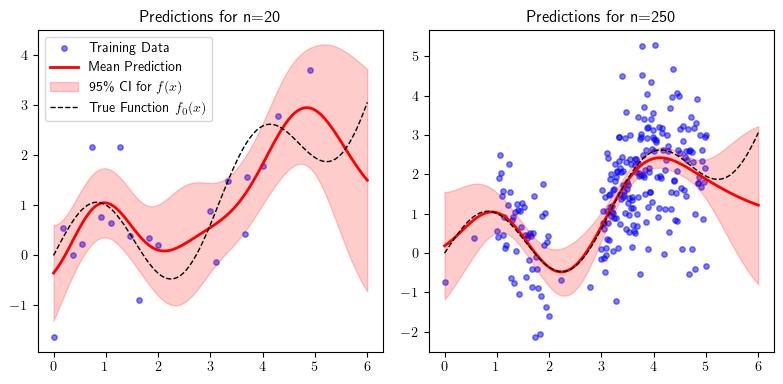

In [99]:
######## Plot the results
# Initialize a figure for the subplot panel
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

x_test_np = np.linspace(0, 6, 100)  # Convert x_test to a numpy array for plotting

# Plot predictions for n=20 and n=250
plot_graph(axes[0], x_train_20, y_train_20, predictions_20, 'Predictions for n=20', 'red')
plot_graph(axes[1], x_train_250, y_train_250, predictions_250, 'Predictions for n=250', 'red', legend = False)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

## Impact of GP Hyperparameters: Table 2

Below we illustrate providing fixed GP model hyperparameters (namely the outputscale $\eta^2$ and the input lengthscale $\theta$) versus optimizing them via MLE for the synthetic function above. We utilize 50 training inputs and use the Matern-5/2 kernel.

This first code chunk generates the data.

In [100]:
# Seed for reproducibility
seed = 235789
torch.manual_seed(seed)
np.random.seed(seed)

# Generate synthetic training data with noise
x_train = np.linspace(0, 5, 51)
y_train = f(x_train) + np.random.normal(0, 1, x_train.shape)

# Generate an additional 50 points as test set
x_test = np.linspace(0, 6, 100)
y_test = f(x_test) + np.random.normal(0, 1, x_test.shape)

# Define and set scaler to scale data to unit interval.  Makes fitting more stable.  Must be used on numpy objects.
scaler = MinMaxScaler()
scaler.fit(x_train.reshape(-1, 1))

# Convert to PyTorch tensors for EasyGPR (GPyTorch) 
train_x = torch.tensor(x_train, dtype=torch.float32).view(-1, 1)
train_y = torch.tensor(y_train, dtype=torch.float32)
test_x = torch.tensor(x_test, dtype=torch.float32).view(-1, 1)

# With scaler defined and fit, we can standardize the training and testing x
train_x_std = torch.tensor(scaler.transform(train_x.cpu()), dtype=torch.float32)
test_x_std = torch.tensor(scaler.transform(test_x.cpu()), dtype=torch.float32)

Next, fit models with varying hyperparameters.  As mentioned we use ``kernel="Mat52"``.  The first two cases show how the lengthscales $\ell_{\text{len}}$ and outputscales $\eta^2$ can be set.  The third optimizes over hyperparameters.

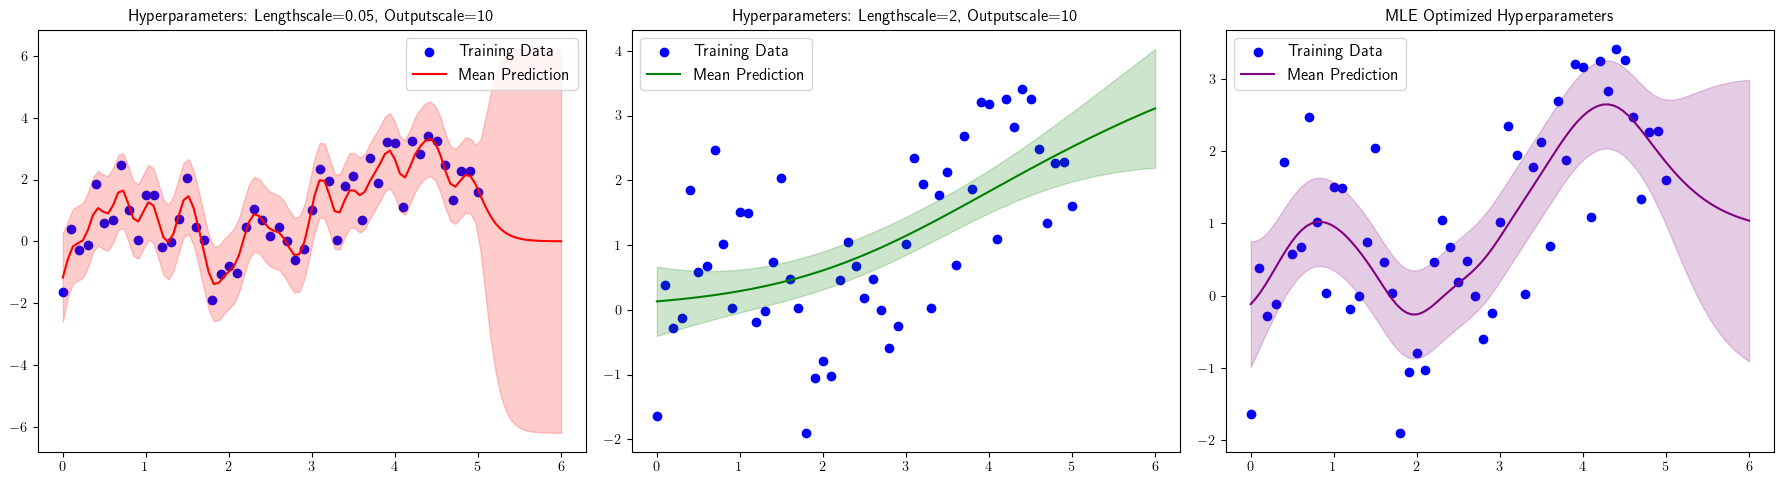

In [101]:
# Very small lengthscale: will overfit
m1 = GPRModel(train_x=train_x_std, train_y=train_y, kernel="Mat52")
m1.covar_module.base_kernel.lengthscale = 0.05
m1.covar_module.outputscale = 10

# Very large lengthscale: will underfit
m2 = GPRModel(train_x=train_x_std, train_y=train_y, kernel="Mat52")
m2.covar_module.base_kernel.lengthscale = 2
m2.covar_module.outputscale = 10

# Optimized lengthscale.  cosine_annealing is optional; can help in certain cases.
m3 = GPRModel(train_x=train_x_std, train_y=train_y, kernel="Mat52")
m3.fit_model(training_iterations=500, cosine_annealing=True, verbose = False)  

# Function to make predictions and plot
def make_plot(model, ax, color, title):
    predictions = model.make_predictions(test_x_std, type="f", return_type="numpy")
    ax.scatter(x_train, y_train, label='Training Data', color='blue')
    ax.plot(x_test, predictions.mean, label='Mean Prediction', color=color)
    ax.fill_between(x_test, predictions.mean - 1.96 * np.sqrt(predictions.variance),
                    predictions.mean + 1.96 * np.sqrt(predictions.variance), alpha=0.2, color=color)
    ax.set_title(title)
    ax.legend()

# Create subplot layout and plot predictions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
make_plot(m1, axes[0], 'red', 'Hyperparameters: Lengthscale=0.05, Outputscale=10')
make_plot(m2, axes[1], 'green', 'Hyperparameters: Lengthscale=2, Outputscale=10')
make_plot(m3, axes[2], 'purple', 'MLE Optimized Hyperparameters')

plt.tight_layout()
plt.show()



For a more rigorous self-assessment we define a helper function to compute model RMSE and BIC metrics

In [102]:
from sklearn.metrics import mean_squared_error

# Function to calculate RMSE and BIC
def calculate_metrics(model, train_x, train_y, test_x, test_y):
    train_pred = model.make_predictions(train_x, type="f", return_type="numpy")
    test_pred = model.make_predictions(test_x, type="f", return_type="numpy")
    
    train_rmse = np.sqrt(mean_squared_error(train_y.cpu().numpy(), train_pred.mean))
    test_rmse = np.sqrt(mean_squared_error(test_y, test_pred.mean))
    
    bic = model.bic
    
    return train_rmse, test_rmse, bic

We now gather the results of all four models into a table (see **Table 2** in Section 2.5 of the Chapter)

In [103]:
# Train another GP model with the exponential Matern-1/2 kernel
m4 = GPRModel(train_x=train_x_std, train_y=train_y, kernel="Exponential")  # equivalently, use kernel = "M12"
m4.fit_model(training_iterations=500, cosine_annealing=True, verbose = False)

# Gather metrics and hyperparameters for table
models = [m1, m2, m3, m4]
data = []
for i, model in enumerate(models, 1):
    lengthscale = round(model.covar_module.base_kernel.lengthscale.item(), 4)
    outputscale = round(model.covar_module.outputscale.item(), 4)
    noise = round(model.likelihood.noise.item(), 4)
    model.compute_bic()
    train_rmse, test_rmse, bic = calculate_metrics(model, train_x_std, train_y, test_x_std, y_test)
    bic = bic.item()
    data.append([f'm{i}', lengthscale, outputscale, noise, round(bic, 4), round(train_rmse, 4), round(test_rmse, 4)])

# Create a DataFrame of results
df = pd.DataFrame(data, columns=["Model", "Lengthscale", "Outputscale", "Noise", "BIC", "Train RMSE", "Test RMSE"])
df


,Model,Lengthscale,Outputscale,Noise,BIC,Train RMSE,Test RMSE
0,m1,0.0500,10.0000,0.6931,95.9992,0.4345,1.3778
1,m2,2.0000,10.0000,0.6931,92.8866,1.0425,1.0835
2,m3,0.1705,1.1346,0.7706,81.5283,0.8164,1.0663
3,m4,0.1669,1.2825,0.5516,81.2248,0.5983,1.0738


The next two code chunks provide two ways of visualizing the four fits.

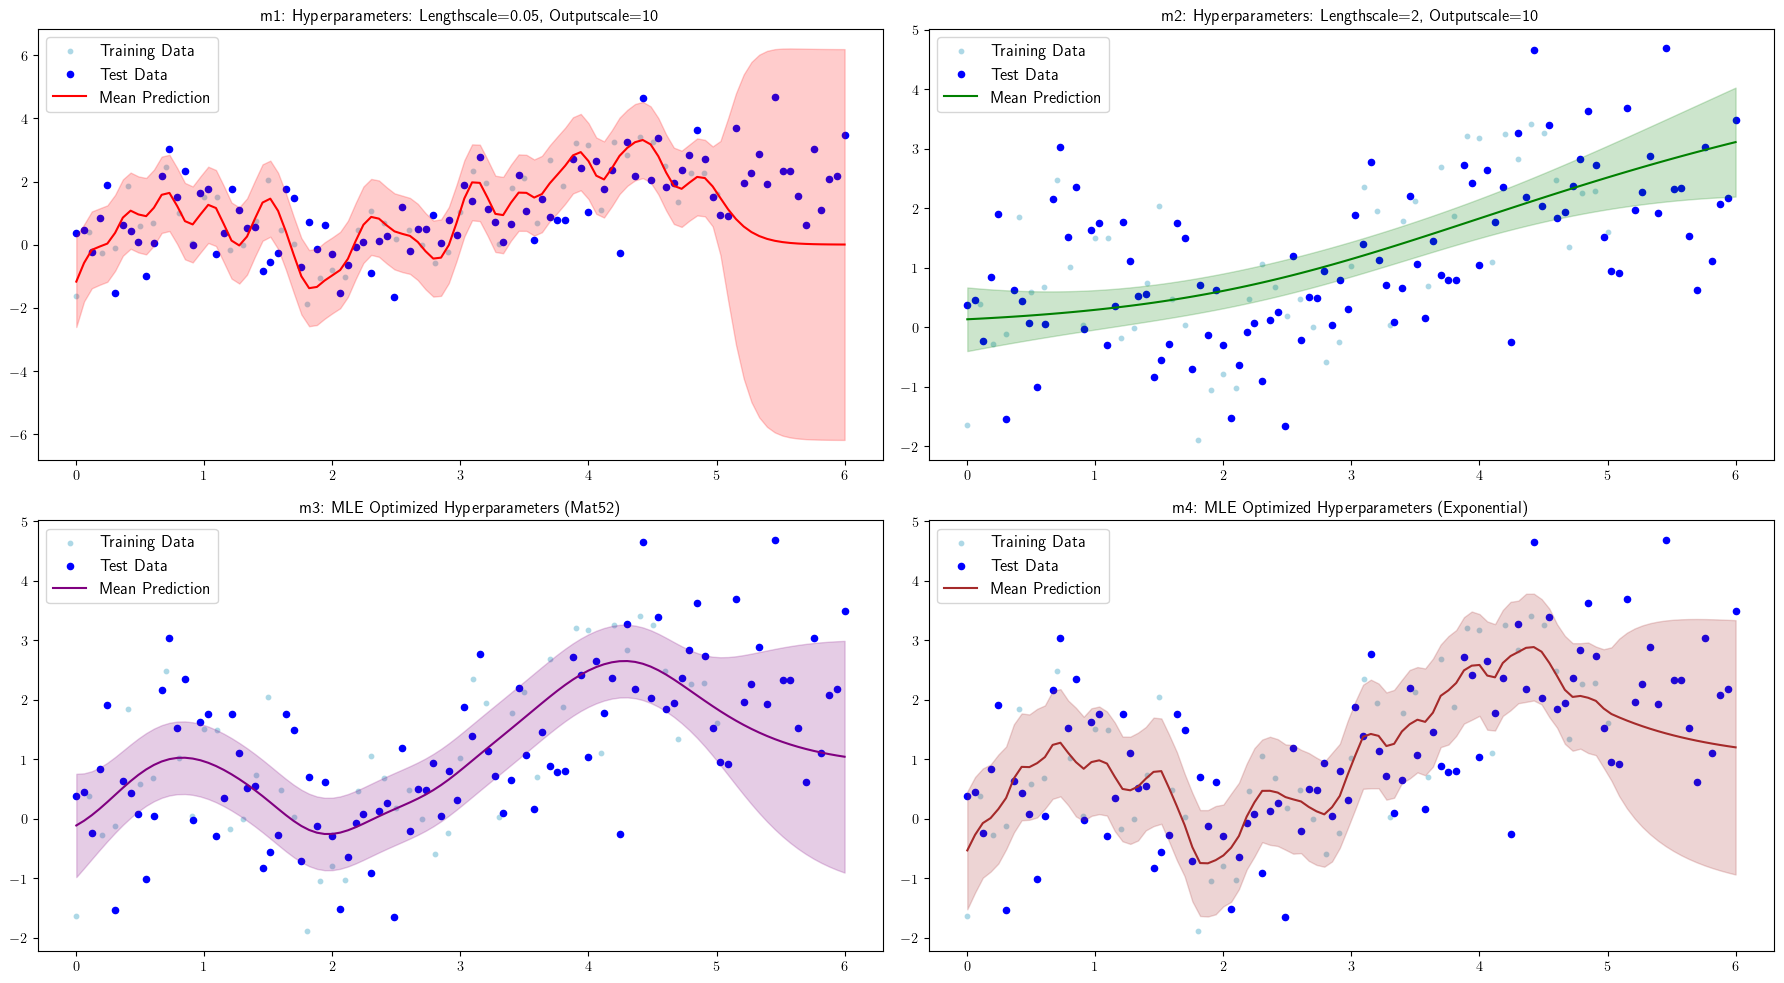

In [104]:
# Function to make enhanced plots utilizing both training and test sets
def make_enhanced_plot(model, ax, color, title):
    predictions = model.make_predictions(test_x_std, type="f", return_type="numpy")
    ax.scatter(x_train, y_train, label='Training Data', color='lightblue', s=10)
    ax.scatter(x_test, y_test, label='Test Data', color='blue', s=20)
    ax.plot(x_test, predictions.mean, label='Mean Prediction', color=color)
    ax.fill_between(x_test, 
                    predictions.mean - 1.96 * np.sqrt(predictions.variance),
                    predictions.mean + 1.96 * np.sqrt(predictions.variance), 
                    alpha=0.2, color=color)
    ax.set_title(title)
    ax.legend()

# Create subplot layout and plot predictions with enhanced visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
make_enhanced_plot(m1, axes[0, 0], 'red', 'm1: Hyperparameters: Lengthscale=0.05, Outputscale=10')
make_enhanced_plot(m2, axes[0, 1], 'green', 'm2: Hyperparameters: Lengthscale=2, Outputscale=10')
make_enhanced_plot(m3, axes[1, 0], 'purple', 'm3: MLE Optimized Hyperparameters (Mat52)')
make_enhanced_plot(m4, axes[1, 1], 'brown', 'm4: MLE Optimized Hyperparameters (Exponential)')

plt.tight_layout()
plt.show()

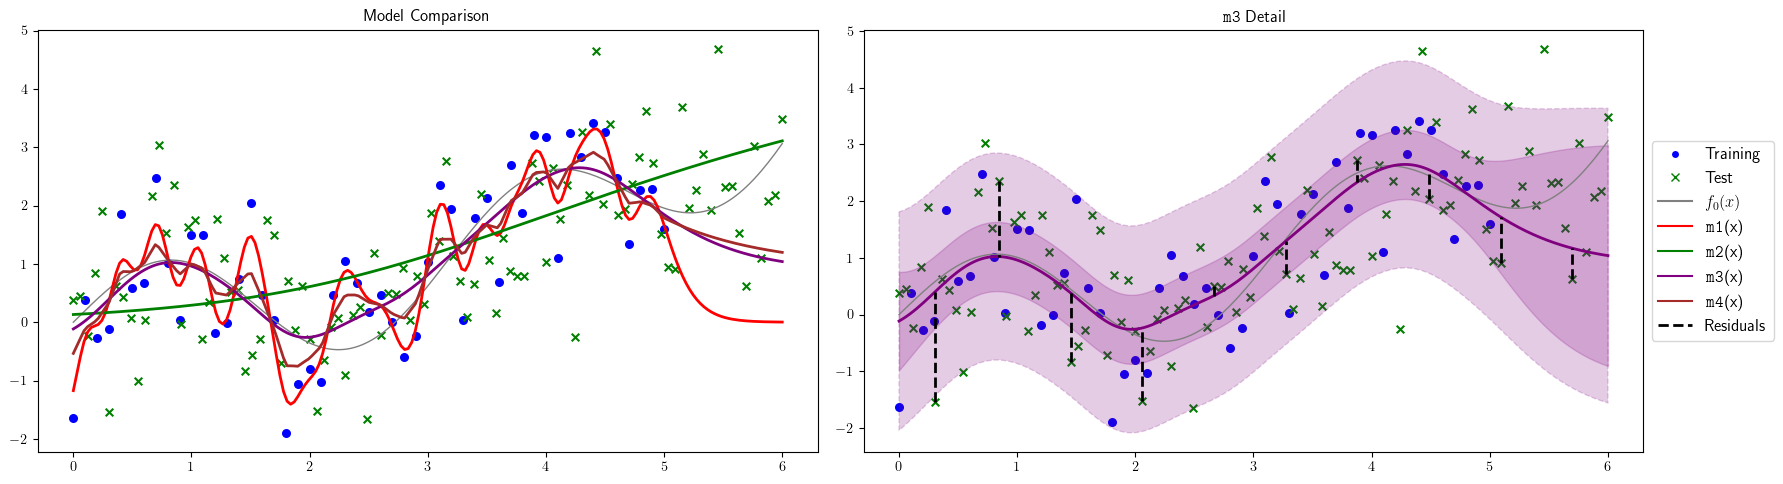

In [105]:
from matplotlib.lines import Line2D

# Preparations
x_mesh = np.linspace(0, 6, 200)
f_0 = 0.1 * x_mesh**2 + np.sin(2 * x_mesh)
x_mesh_std = torch.tensor(scaler.transform(x_mesh.reshape(-1, 1)), dtype=torch.float32)

# Set names for the models for easier referencing in the plot labels
m1.name, m2.name, m3.name, m4.name = '\\texttt{m1}', '\\texttt{m2}', '\\texttt{m3}', '\\texttt{m4}'

# Plotting setup
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
models = [m1, m2, m3, m4]
colors = ['red', 'green', 'purple', 'brown']

# Plot for all models
ax = axes[0]
ax.plot(x_mesh, f_0, color='grey', linestyle='-', linewidth=1, label='$f_0(x) = 0.1x^2 + \sin(2x)$')
ax.scatter(x_train, y_train, label='Training', color='blue', s=30, marker='o')
ax.scatter(x_test, y_test, label='Test', color='green', s=30, marker='x')
for model, color in zip(models, colors):
    predictions = model.make_predictions(x_mesh_std, type="f", return_type="numpy")
    ax.plot(x_mesh, predictions.mean, label=f'{model.name}', color=color, linewidth=2)
ax.set_title('Model Comparison')

# Detailed plot for m3 with confidence intervals and residuals
ax = axes[1]
model, color = m3, 'purple'
ax.plot(x_mesh, f_0, color='grey', linestyle='-', linewidth=1)
ax.scatter(x_train, y_train, color='blue', s=30, marker='o')
ax.scatter(x_test, y_test, color='green', s=30, marker='x')
predictions_f = model.make_predictions(x_mesh_std, type="f", return_type="numpy")
predictions_y = model.make_predictions(x_mesh_std, type="y", return_type="numpy")
ax.plot(x_mesh, predictions_f.mean, label=f'{model.name}', color=color, linewidth=2)
ax.fill_between(x_mesh, predictions_f.mean - 1.96 * np.sqrt(predictions_f.variance),
                predictions_f.mean + 1.96 * np.sqrt(predictions_f.variance), alpha=0.2, color=color,
                label='95% CI for f')
ax.fill_between(x_mesh, predictions_y.mean - 1.96 * np.sqrt(predictions_y.variance),
                predictions_y.mean + 1.96 * np.sqrt(predictions_y.variance), alpha=0.2, color=color,
                linestyle='dashed', label='95\% PI for y')
selected_indices = np.linspace(5, len(x_test) - 6, 10, dtype=int)
for idx in selected_indices:
    x_val, y_val = x_test[idx], y_test[idx]
    y_pred = float(model.make_predictions(torch.tensor(scaler.transform([[x_val]]), dtype=torch.float32), type="f", return_type="numpy").mean)
    ax.plot([x_val, x_val], [y_val, y_pred], color='black', linestyle='--', linewidth=2)
ax.set_title('\\texttt{m3} Detail')

# Unified Legend for both subplots
custom_handles = [
    Line2D([0], [0], marker='o', color='w', label='Training', markerfacecolor='blue', linestyle='None'), 
    Line2D([0], [0], marker='x', color='green', label='Test', markerfacecolor='green', linestyle='None'), 
    Line2D([0], [0], linestyle='-', color='grey', label='$f_0(x)$'),
    *[
        Line2D([0], [0], linestyle='-', color=color, label=f'\\texttt{{m{i+1}}}(x)') for i, color in enumerate(colors)
    ],
    Line2D([0], [0], linestyle='--', color='black', linewidth=2, label='Residuals')
]
axes[1].legend(handles=custom_handles, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()